In [4]:
import pygmt
import pandas as pd
import geopandas as gpd
import xarray as xr
from pyproj import Transformer
from scipy.spatial import cKDTree
import rioxarray

# Calculate distances to nearest constraints

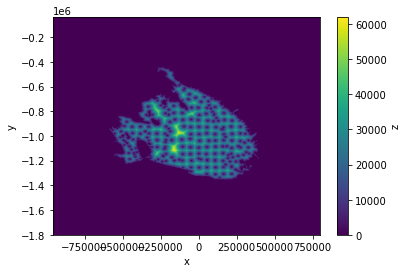

In [5]:
constraints = pd.read_csv('../bathymetry_data/bedmachine_RIGGS.csv', index_col=False,) # from RIS_bathymetry_data.ipynb
grid=xr.load_dataset('../bathymetry_data/bedmachine_clip.nc') # from RIS_bathymetry_data.ipynb

A = grid.to_dataframe().reset_index()[['x','y']].values
B = constraints[['x','y']].values

min_dists, min_dist_idx = cKDTree(B).query(A,1)

dists = pd.DataFrame(A, columns=('x','y'))
dists['min_dists']=min_dists
dist_grid = pygmt.xyz2grd(dists, region='../bathymetry_data/bedmachine_clip.nc', spacing=1000)
dist_grid.plot()

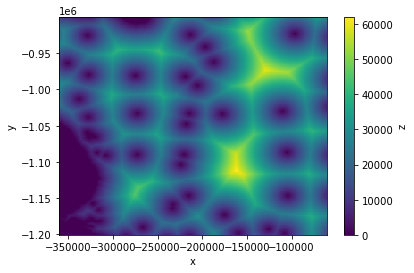

In [6]:
dist_grid.isel(x=slice(600,900), y=slice(600,900)).plot()

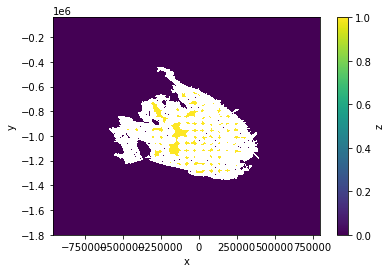

In [7]:
outer = 30e3
inner = 2e3
# if distance to nearest constraint > outer, set to 1 (fully free to invert)
# if distance to nearest constraint < inner, set to 0 (completely constrained)
# if distance to nearest constraint between inner and out, set to NaN 
dist_clip = pygmt.grdclip(
    dist_grid, 
    above=[outer,1],
    below=[inner,0],
    between=[inner, outer, 'NaN']
    )
dist_clip.plot()

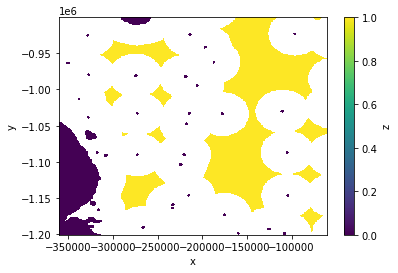

In [8]:
dist_clip.isel(x=slice(600,900), y=slice(600,900)).plot()

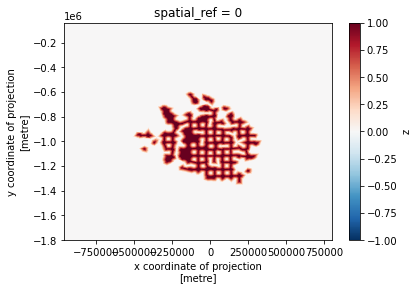

In [12]:
# if distance between inner and outer, linearly increase from 0 to 1
dist_clip=dist_clip.rio.write_crs("epsg:3031")
constraints_grid = dist_clip.rio.interpolate_na(method='linear')
constraints_grid.plot()

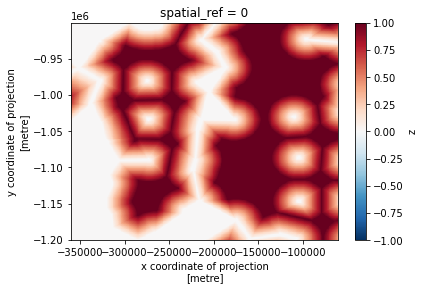

In [13]:
constraints_grid.isel(x=slice(600,900), y=slice(600,900)).plot()

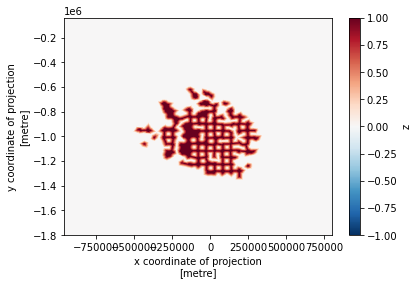

In [14]:
constraints_grid.to_netcdf('constraints_grid.nc')
xr.load_dataset('constraints_grid.nc').z.plot()

In [ ]:
t